# 基于谱神经算子的伯格斯方程求解

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/zh_cn/data_driven/mindspore_burgers_SNO1D.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/zh_cn/data_driven/mindspore_burgers_SNO1D.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_zh_cn/data_driven/burgers_SNO1D.ipynb)

## 概述

计算流体力学是21世纪流体力学领域的重要技术之一，其通过使用数值方法在计算机中对流体力学的控制方程进行求解，从而实现流动的分析、预测和控制。传统的有限元法（finite element method，FEM）和有限差分法（finite difference method，FDM），常用于复杂的仿真流程（物理建模、网格划分、数值离散、迭代求解等），其较高的计算成本，导致求解效率往往较为低下。因此，借助AI提升流体仿真效率是十分必要的。

近年来，随着神经网络的迅猛发展，为科学计算提供了新的范式。经典的神经网络是在有限维度的空间进行映射，只能学习与特定离散化相关的解。与经典神经网络不同，傅里叶神经算子（Fourier Neural Operator，FNO）是一种能够学习无限维函数空间映射的新型深度学习架构。该架构可直接学习从任意函数参数到解的映射，用于解决一类偏微分方程的求解问题，具有更强的泛化能力。更多信息可参考[Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895)。

谱神经算子（Spectral Neural Operator，SNO）是利用多项式将计算变换到频谱空间（Chebyshev,Legendre等）的类似FNO的架构。与FNO相比, SNO的特点是由混淆误差引起的系统偏差较小。其中最重要的好处之一是SNO的基的选择更为宽泛，因此可以在其中找到一组最方便表示的多项式。例如，针对问题的对称性或针对时间间隔来选取适应的基。此外，当输入定义在在非结构化网格上时，基于正交多项式的神经算子相比其他谱算子或更有竞争力。

更多信息可参考, "[Spectral Neural Operators](https://arxiv.org/abs/2205.10573)". arXiv preprint arXiv:2205.10573 (2022).

本案例教程介绍了利用频谱神经算子求解1-d Burgers方程的方法。

## 伯格斯方程（Burgers' equation）

一维伯格斯方程（1-d Burgers' equation）是一个非线性偏微分方程，具有广泛应用，包括一维粘性流体流动建模。它的形式如下：

$$
\partial_t u(x, t)+\partial_x (u^2(x, t)/2)=\nu \partial_{xx} u(x, t), \quad x \in(0,1), t \in(0, 1]
$$

$$
u(x, 0)=u_0(x), \quad x \in(0,1)
$$

其中$u$表示速度场，$u_0$表示初始条件，$\nu$表示粘度系数。

## 问题描述

本案例利用Spectral Neural Operator学习初始状态到下一时刻状态的映射，实现一维Burgers'方程的求解：

$$
u_0 \mapsto u(\cdot, 1)
$$

## 技术路径

MindFlow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 优化器与损失函数。
4. 模型训练。
5. 模型推理和可视化。

## 谱神经算子

下图显示了谱神经算子的架构，它由编码器、多层谱卷积层（谱空间的线性变换）和解码器组成。要计算频谱卷积的正向和逆多项式变换矩阵，应在相应的Gauss正交节点（Chebyshev网格等）对输入进行插值。通过卷积编码层将插值后的输入提升到更高维度的通道。其结果将经过多层谱卷积层，每个层对其截断的谱表示应用线性卷积。SNO层的输出通过卷积解码器投影回目标维度，最后插值回原始节点。

SNO层执行以下操作：将多项式变换$A$应用于光谱空间（Chebyshev，Legendre等）操作；多项式低阶模态上的线性卷积$L$操作，高阶模态上的过滤操作；而后，应用逆变换 $S={A}^{-1}$（回到物理空间）。然后添加输入层的线性卷积 $W$操作，并应用非线性激活层。

![SNO网络结构](images/SNO.png)

In [1]:
import os
import time
import numpy as np

from mindspore import context, nn, Tensor, set_seed, ops, data_sink, jit, save_checkpoint
from mindspore import dtype as mstype
from mindflow.cell import SNO1D, get_poly_transform
from mindflow import RelativeRMSELoss, load_yaml_config, get_warmup_cosine_annealing_lr
from mindflow.pde import UnsteadyFlowWithLoss
from mindflow.utils import print_log

下述`src`包可以在[applications/data_driven/burgers/sno1d/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/data_driven/burgers/sno1d/src)下载。

In [2]:
from src import create_training_dataset, load_interp_data, test_error, visual

set_seed(0)
np.random.seed(0)

context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

从[config](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/applications/data_driven/burgers/sno1d/configs/sno1d.yaml)中获得模型、数据、优化器的超参。

In [4]:
config = load_yaml_config('./configs/sno1d.yaml')
data_params = config["data"]
model_params = config["model"]
optimizer_params = config["optimizer"]
summary_params = config["summary"]

## 创建数据集

下载训练与测试数据集: [data_driven/burgers/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/data_driven/burgers/dataset/)。

本案例根据Zongyi Li在 [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf) 一文中对数据集的设置生成训练数据集与测试数据集。具体设置如下：
基于周期性边界，生成满足如下分布的初始条件$u_0(x)$：

$$
u_0 \sim \mu, \mu=\mathcal{N}\left(0,625(-\Delta+25 I)^{-2}\right)
$$

本案例选取粘度系数$\nu=0.1$，并使用分步法求解方程，其中热方程部分在傅里叶空间中精确求解，然后使用前向欧拉方法求解非线性部分。训练集样本量为1000个，测试集样本量为200个。

In [5]:
poly_type = data_params['poly_type']

# create training dataset
load_interp_data(data_params, dataset_type='train')
train_dataset = create_training_dataset(data_params, shuffle=True)

# create test dataset
test_data = load_interp_data(data_params, dataset_type='test')
test_input = Tensor(test_data['test_inputs'], mstype.float32)
test_label = Tensor(test_data['test_labels'], mstype.float32)

## 构建模型

网络由1个Encoding layer、多个Spectral layer和Decoding block组成:

- 编码卷积在情况下对应`SNO1D.encoder`，将输入数据$x$映射到高维；

- 在这种情况下,SNO层序列对应于`SNO1D.sno_kernel`。利用多项式变换的输入矩阵实现时空域与频域的转换；

- 解码层对应`SNO1D.decoder`，由两个卷积组成。解码器用于获得最终预测。

基于上述网络结构，进行模型初始化，其中模型参数可在[配置文件](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/applications/data_driven/burgers/sno1d/configs/sno1d.yaml)中修改。

In [6]:
n_modes = model_params['modes']
resolution = data_params['resolution']

transform_data = get_poly_transform(resolution, n_modes, poly_type)

transform = Tensor(transform_data["analysis"], mstype.float32)
inv_transform = Tensor(transform_data["synthesis"], mstype.float32)

In [7]:
model = SNO1D(in_channels=model_params['in_channels'],
              out_channels=model_params['out_channels'],
              hidden_channels=model_params['hidden_channels'],
              num_sno_layers=model_params['sno_layers'],
              transforms=[[transform, inv_transform]],
              compute_dtype=mstype.float32)

model_params_list = []
for k, v in model_params.items():
    model_params_list.append(f"{k}:{v}")
model_name = "_".join(model_params_list)
print(model_name)
total = 0
for param in model.get_parameters():
    print_log(param.shape)
    total += param.size
print_log(f"Total Parameters:{total}")

root_dir:./_name:SNO1D_in_channels:1_out_channels:1_hidden_channels:128_sno_layers:6_modes:15
(128, 1, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 5)
(128, 128, 1, 1)
(128, 128, 1, 1)
(1, 128, 1, 1)
Total Parameters:606464


## 优化器与损失函数

In [8]:
steps_per_epoch = train_dataset.get_dataset_size()

lr = get_warmup_cosine_annealing_lr(lr_init=optimizer_params["learning_rate"],
                                    last_epoch=optimizer_params["epochs"],
                                    steps_per_epoch=steps_per_epoch,
                                    warmup_epochs=1)

optimizer = nn.AdamWeightDecay(model.trainable_params(), learning_rate=Tensor(lr),
                               weight_decay=optimizer_params['weight_decay'])

## 模型训练

使用 **MindSpore version >= 2.0.0**, 我们可以使用函数式编程来训练神经网络。 `MindFlow` 为非稳态问题 `UnsteadyFlowWithLoss` 提供了一个训练接口，用于模型训练和评估。

In [9]:
problem = UnsteadyFlowWithLoss(model, loss_fn=RelativeRMSELoss(), data_format="NTCHW")

def forward_fn(data, label):
    loss = problem.get_loss(data, label)
    return loss

grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

@jit
def train_step(data, label):
    loss, grads = grad_fn(data, label)
    grads = ops.clip_by_global_norm(grads, optimizer_params['grad_clip_norm'])

    loss = ops.depend(loss, optimizer(grads))
    return loss

sink_process = data_sink(train_step, train_dataset, 1)

summary_dir = summary_params["summary_dir"]
os.makedirs(summary_dir, exist_ok=True)
ckpt_dir = summary_params['ckpt_dir']
os.makedirs(ckpt_dir, exist_ok=True)

for epoch in range(1, optimizer_params["epochs"] + 1):
    local_time_beg = time.time()
    model.set_train(True)
    for _ in range(steps_per_epoch):
        cur_loss = sink_process()

    if epoch % 2 == 0:
        print_log(f"epoch: {epoch} train loss: {cur_loss.asnumpy()} epoch time: {time.time() - local_time_beg:.2f}s")

    model.set_train(False)
    if epoch % summary_params["save_ckpt_interval"] == 0:
        save_checkpoint(model, os.path.join(ckpt_dir, f"{model_params['name']}_epoch{epoch}"))

    if epoch % summary_params['test_interval'] == 0:
        test_error(model, test_input, test_label, data_params)

epoch: 2 train loss: 13.560559272766113 epoch time: 0.29s
epoch: 4 train loss: 7.8073320388793945 epoch time: 0.29s
epoch: 6 train loss: 5.312091827392578 epoch time: 0.29s
epoch: 8 train loss: 4.512760162353516 epoch time: 0.29s
epoch: 10 train loss: 4.524318695068359 epoch time: 0.29s
================================Start Evaluation================================
poly err 0.082584664 unif err 0.08160467609741283
mean rel_rmse_error:
on Gauss grid: 0.082584664, on regular grid: 0.08160467609741283
=================================End Evaluation=================================
predict total time: 0.9047303199768066 s
epoch: 12 train loss: 3.368042230606079 epoch time: 0.29s
epoch: 14 train loss: 3.7890400886535645 epoch time: 0.29s
epoch: 16 train loss: 2.914067268371582 epoch time: 0.29s
epoch: 18 train loss: 3.0474812984466553 epoch time: 0.29s
epoch: 20 train loss: 2.3820204734802246 epoch time: 0.29s
================================Start Evaluation================================

In [10]:
visual(model, test_input, data_params)

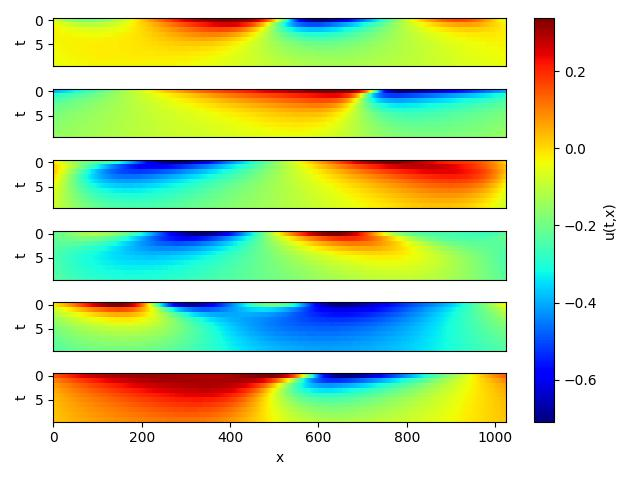

In [12]:
from IPython.display import Image, display

display(Image(filename='images/result.jpg', embed=True))